-Il faut mettre les graphs avec widgets dans un autre notebook
-Il faut remettre les graphs avec widgets en graphs normaux
-Il faut finir de mettre les titres et les explications sur chaque graph
-Vérifier que pour les boites à moustaches j'affiche la moyenne et la médiane

# Imports

In [1]:
# On importe les librairies dont on a besoin
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn import decomposition
from sklearn import preprocessing

In [2]:
# On importe le fichier csv depuis l'url

#Téléchargement de l'archive depuis l'adresse web
#request = requests.get("https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip")
# on décompresse le fichier
#zippedData = request.content
#output = open("data",'wb')
#output.write(zippedData)
#output.close()
#with ZipFile("data", 'r') as zip:
#    zip.printdir()
#    zip.extractall()

# on charge le fichier dans un dataFrame
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', decimal=".", low_memory=False)

# Fonctions

In [3]:
# Fonction qui renvoie une liste de couleur à partir du dataFrame, de la colonne à traiter
# et d'un dictionnaire contenant les valeurs et les couleurs à appliquer
#Ex: Utilisé pour visualiser le nutriscore par couleur
def pltcolor(unDataFrame, uneVariable, unDict):
    cols=[]
    for uneCategorie in unDataFrame[uneVariable]:
        if uneVariable == 'nutrition-score-fr_100g':
            cols.append(unDict[getNutriscore(uneCategorie)])
        else:
            cols.append(unDict[uneCategorie])
    return cols

In [4]:
# Fonction pour faire un tableau de fréquence des modalités pour une variable passée en paramètre 
# La fonction prend 2 paramètres : le nom de la variable telle qu'elle est dans le dataset
# et le rang à partir duquel on regroupe les variables dans autre

def frequence(DataFreq, variable, rangAutre = 5):
    DataFreq.fillna('non renseigné', inplace=True) # on remplace les informations absentes par "non renseigné"
    effectifs = DataFreq[variable].value_counts(dropna= False) # On récupère la série qui contient les modalités et leurs effectifs

    modalites = effectifs.index # l'index de effectifs contient les modalités

    tab = pd.DataFrame(modalites,columns = ["modalités"]) # création du tableau à partir des modalités
    tab["fréquences"] = (effectifs.values*100) / len(DataFreq) # len(data) renvoie la taille de l'échantillon

    tab = tab.sort_values("fréquences",ascending=False) # tri des valeurs de la variable X (décroissant)

    tabAgreg = tab.copy() # copie par valeur du tableau

    effectif_autre = 0
    frequence_autre = 0
    frequence_cumul_autre = 0
    nb = 0
    
    # on regroupe les valeurs dans autre à partir du rang rangAutre passé en paramètre
    for i in tabAgreg.index:
        nb += 1
        if nb > rangAutre: # cumsum calcule la somme cumulée
            frequence_autre += tabAgreg["fréquences"][i]
            tabAgreg.drop(labels = i,axis='index',inplace=True) # on supprime les lignes cumulées
    
    pdAutre = pd.DataFrame({'modalités' : ['Autres'],'fréquences' : [frequence_autre]}) # on crée un dataset pour la ligne autre     

    if frequence_autre > 0 :
        tabAgreg = tabAgreg.append(pdAutre) # on l'ajoute au tableau principal
    
    tab_format = tabAgreg.copy() # copy par valeur du tableau avant mise en forme (on copie car le tableau tabAgreg sert à générer les graph et on a besoin de conserver le format initial)
    tab_format["fréquences"] = tab_format["fréquences"].apply(lambda x : "{:.0f}%".format(x) if int(x) == x else "{:.2f}%".format(x)) # formatage des pourcentages
    
    print(tab_format)
    print('\n')
    print("Nombres de modalités : ", len(modalites))
    print('\n')
    return tabAgreg # on renvoit le tableau pour l'édition du graph

In [5]:
# fonction pour générer les graph à secteur
# 2 paramètres : le tableau généré par la fonction précédente avec les données,
# le titre que l'on veut donner au graph

def graph(tab, titre_graph = "") :
    
    # fonction de formatage des pourcentages
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.2f}%".format(pct, absolute)
    
    #Génération du paramétrage de dispersion des secteurs
    explode = ()
    val = 0.3
    for i in tab.index:        
        explode += (val,)
        val = max(val-0.1, 0.1)
        
    # Creation du graph
    fig, ax = plt.subplots(figsize=(10, 7))
    wedges, texts, autotexts = ax.pie(tab['fréquences'], autopct=lambda pct: func(pct, tab['fréquences']), explode=explode, labels=tab['modalités'],
                                      shadow=True, startangle=90)

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(titre_graph,y = 1.1)

In [6]:
# fonction qui renvoie le nutriscore sous forme de lettre à partir de la note chiffrée

def getNutriscore(valeur):
    if valeur >= -15  and valeur <=-2:
        return "A"
    elif valeur >= -1 and valeur <= 3:
        return "B"
    elif valeur >= 4 and valeur <= 11:
        return "C"
    elif valeur >= 12 and valeur <= 16:
        return "D"
    elif valeur >= 17 and valeur <= 40:
        return "E"

In [7]:
# Fonction de calcul d'eta² pour l'ANOVA
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [8]:
# Fonction de création du cercle de corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [9]:
# Fonction de projection des valeurs sur le cercle des correlations
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, colors=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, c=colors, s=1)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    color = colors[selected]
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=color, s=1)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Description des données

Les données sont décrites à partir des bibliothèques python via l'application Jupyter

In [10]:
# Edition des informations générales
print('Nombre d\'échantillons: ', data.shape[0])
print('Nombre de variables : ', data.shape[1])

Nombre d'échantillons:  320772
Nombre de variables :  162


In [11]:
# Nombre de variables par intervalles de taux de données manquantes
print("Répartition des variables en fonction du taux de données absentes.")
ser = data.isna().mean().sort_values()
binnedSer = pd.cut(ser,10)
binnedSer.value_counts(sort = False)

Répartition des variables en fonction du taux de données absentes.


(-0.001, 0.1]     16
(0.1, 0.2]         2
(0.2, 0.3]        11
(0.3, 0.4]         5
(0.4, 0.5]         0
(0.5, 0.6]         8
(0.6, 0.7]         1
(0.7, 0.8]        11
(0.8, 0.9]         8
(0.9, 1.0]       100
dtype: int64

Sur 162 variables 129 d'entre elles sont vides à plus de 50%, dont 100 à plus de 90%

In [12]:
serSup60 = ser[ser <= 0.4]
var_etudiable = list(serSup60.index)
print('Nombre de variables avec moins de 40% de données absentes : ',len(var_etudiable))

Nombre de variables avec moins de 40% de données absentes :  34


In [13]:
print('Liste des variables avec moins de 40% de données absentes :', var_etudiable)

Liste des variables avec moins de 40% de données absentes : ['last_modified_t', 'last_modified_datetime', 'creator', 'created_t', 'created_datetime', 'code', 'url', 'states', 'states_tags', 'states_fr', 'countries_fr', 'countries', 'countries_tags', 'product_name', 'brands', 'brands_tags', 'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'ingredients_text', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'ingredients_from_palm_oil_n', 'additives', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'nutrition-score-uk_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr', 'serving_size', 'fiber_100g']


Les variables redondantes ou qui ne présentent que peu d'intérêt pour l'utilisateur sont laissées de côté :

In [14]:
# Variables supprimées car redondance :
#'last_modified_t', 'created_t','states','states_tags','countries','countries_tags','brands_tags',

# Variables qui n'ont que peut d'intérêt par rapport à l'utilisateur
# 'last_modified_datetime','creator','created_datetime','states_fr',

# On conserve la variable main_category_fr qui est peut renseignée mais qui a un intérêt majeur pour l'étude

quali = ['code','url','countries_fr','product_name','brands','ingredients_text','additives','main_category_fr']
quanti_100g = ['proteins_100g','sodium_100g','fat_100g','carbohydrates_100g','fiber_100g']
quanti_nbr = ['additives_n']
quanti_energie = ['energy_100g']
quanti_nutriscore = ['nutrition-score-fr_100g']
data_etudiee = data[quali + quanti_100g + quanti_nbr + quanti_energie + quanti_nutriscore].copy()

Liste des 5 premières entrées du dataset étudié :

In [15]:
data_etudiee.head()

,code,url,countries_fr,product_name,brands,ingredients_text,additives,main_category_fr,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,fiber_100g,additives_n,energy_100g,nutrition-score-fr_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,France,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Banana Chips Sweetened (Whole),NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,3.57,0.000,28.57,64.29,3.6,0.0,2243.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Peanuts,Torn & Glasser,"Peanuts, wheat flour, sugar, rice flour, tapio...",[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,17.86,0.250,17.86,60.71,7.1,0.0,1941.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Organic Salted Nut Mix,Grizzlies,"Organic hazelnuts, organic cashews, organic wa...",[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,17.86,0.482,57.14,17.86,7.1,0.0,2540.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Organic Polenta,Bob's Red Mill,Organic polenta,[ organic-polenta -> en:organic-polenta ] [...,NaN,8.57,NaN,1.43,77.14,5.7,0.0,1552.0,NaN


In [16]:
print("Taux de données absentes pour les variables conservées pour la suite des traitements.")
data_etudiee.isna().mean().sort_values(ascending=False)

Taux de données absentes pour les variables conservées pour la suite des traitements.


main_category_fr           0.736991
fiber_100g                 0.373742
nutrition-score-fr_100g    0.310382
carbohydrates_100g         0.240620
fat_100g                   0.239675
additives                  0.224044
additives_n                0.223938
ingredients_text           0.223866
sodium_100g                0.203599
proteins_100g              0.189699
energy_100g                0.185986
brands                     0.088574
product_name               0.055373
countries_fr               0.000873
code                       0.000072
url                        0.000072
dtype: float64

Ordre de grandeur des variables quantitatives avant nettoyage

# Nettoyage des données

- Détection des doublons (On se base sur une clef composée code / url du produit) l'idéal aurait été une clef composée code / stores mais stores est très peu renseignée. On comble les données url ou code absents par "non renseignée".


In [17]:
# Information sur le détail des nettoyages
nbLignesSupprimees = 0
nbLignesInf0 = 0

# Remplacement des NaN par "non renseignée" pour toutes les variables qualitatives
data_etudiee[quali] = data_etudiee[quali].fillna("non renseignée")

# Suppression des lignes qui n'ont pas de nutriscore car nous n'avons pas toutes les données pour le recalculer
idNutrAbs = data_etudiee[data_etudiee['nutrition-score-fr_100g'].isna()].index
nbLignesSupprimees += len(idNutrAbs)
# Suppression des lignes
data_etudiee = data_etudiee.drop(idNutrAbs)

# On remplace les données quanti manquantes par la moyenne des valeurs
# On pourait affiner en appliquant la moyenne de la catégorie mais de nombreuses catégories sont non renseignées
# On pourait aussi combler les quantités absentes par soustractions des quantités connues au total des 100g
# ou à partir de la valeur énergétique du produit. Malheureusement la variabilité des situations possibles
# rend l'algorithme complexe à mettre en place

data_etudiee[quanti_100g + quanti_energie + quanti_nbr] = \
data_etudiee[quanti_100g + quanti_energie + quanti_nbr].fillna(data_etudiee[quanti_100g + quanti_energie + quanti_nbr].mean())

# Décompte des lignes dupliquées sur le couple code/url
isDuplicated = data_etudiee[data_etudiee.duplicated(subset=['code', 'url'])].index
nbLignesSupprimees += len(isDuplicated)
# Suppression des lignes
data_etudiee = data_etudiee.drop(isDuplicated)

# Décompte des lignes ou une variable quantitative est < 0
idInf0 = []
for variable in data_etudiee[quanti_100g] :
    idInf0 = data_etudiee[data_etudiee[variable]<0].index
    nbLignesSupprimees += len(idInf0)
    nbLignesInf0 += len(idInf0)
    # Suppression des lignes
    data_etudiee = data_etudiee.drop(idInf0)

# Décompte des lignes ou la somme des quantités de macronutriments est > 100g
idSommeSup100 = data_etudiee[(data_etudiee['proteins_100g']\
                             + data_etudiee['sodium_100g']\
                             + data_etudiee['carbohydrates_100g']\
                             + data_etudiee['fat_100g']\
                             + data_etudiee['fiber_100g']) > 100].index
nbLignesSupprimees += len(idSommeSup100)
# Suppression des lignes
data_etudiee = data_etudiee.drop(idSommeSup100)
            
# Décompte des lignes ou le calcul de la valeur énergétique est supérieur à celle fournie
idEnergieInco = data_etudiee[(data_etudiee['proteins_100g']*16.72)\
                             + (data_etudiee['carbohydrates_100g']*16.72)\
                             + (data_etudiee['fat_100g']*37.62) > data_etudiee['energy_100g'] ].index
nbLignesSupprimees += len(idEnergieInco)
# Suppression des lignes
data_etudiee = data_etudiee.drop(idEnergieInco)
            
# Décompte des lignes ou l'énergie annoncée dépasse 3762 KJ
idEnergieSup3762 = data_etudiee[data_etudiee['energy_100g'] > (3762) ].index
nbLignesSupprimees += len(idEnergieSup3762)
# Suppression des lignes
data_etudiee = data_etudiee.drop(idEnergieSup3762)

# Décompte des lignes ou le nutriscore < -15
idNutrInfMoins15 = data_etudiee[data_etudiee['nutrition-score-fr_100g'] < -15].index
nbLignesSupprimees += len(idNutrInfMoins15)
# Suppression des lignes
data_etudiee = data_etudiee.drop(idNutrInfMoins15)

# Décompte des lignes ou le nutriscore > 40
idNutrSup40 = data_etudiee[data_etudiee['nutrition-score-fr_100g'] > 40].index
nbLignesSupprimees += len(idNutrSup40)

# Suppression des lignes
data_etudiee = data_etudiee.drop(idNutrSup40)

# Ajout d'une variable Nutriscore avec une lettre
listeLettreNutrScore = []
for i in range (0, data_etudiee.shape[0]):
    listeLettreNutrScore.append(getNutriscore(data_etudiee['nutrition-score-fr_100g'].iloc[i]))
data_etudiee['nutrition-letter-fr_100g'] = listeLettreNutrScore
quali.append('nutrition-letter-fr_100g')

# Ajout d'une variable nombre d'ingrédients (hors additifs)
data_etudiee["nb_ingredients"] = data_etudiee["ingredients_text"].str.split(",").str.len()

print("Incohérences :")
print("Nombre de lignes ou le couple code/url est dupliqué :", len(isDuplicated))
print("Nombre de lignes sans nutriscore :", len(idNutrAbs))
print("Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g :", len(idInf0))
print("Nombre de lignes ou la somme des quantités de macronutriments dépasse 100g :", len(idSommeSup100))
print("Nombre de lignes ou la valeur énergétique calculée est supérieure à la valeur énergétique annoncée:", len(idEnergieInco))
print("Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ:", len(idEnergieSup3762))
print("Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 :", len(idNutrSup40))
print("Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 :", len(idNutrInfMoins15))
print("Nombre de lignes supprimées au total :", nbLignesSupprimees)

Incohérences :
Nombre de lignes ou le couple code/url est dupliqué : 0
Nombre de lignes sans nutriscore : 99562
Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g : 0
Nombre de lignes ou la somme des quantités de macronutriments dépasse 100g : 20671
Nombre de lignes ou la valeur énergétique calculée est supérieure à la valeur énergétique annoncée: 82843
Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ: 340
Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 : 0
Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 : 0
Nombre de lignes supprimées au total : 203417


# Variables : Etude univariée

<function matplotlib.pyplot.show(close=None, block=None)>

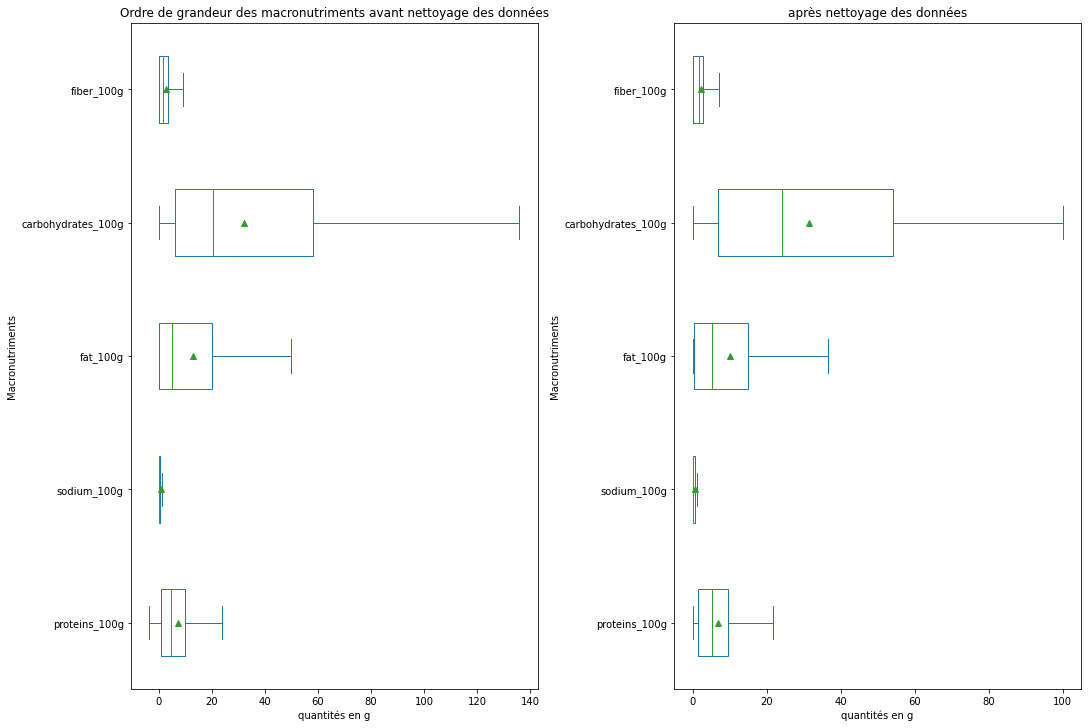

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,10))
ax1 = data_etudiee[quanti_100g].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax1.set_xlabel("quantités en g")
ax1.set_ylabel("Macronutriments")
ax1.set_title("après nettoyage des données")

ax2 = data[quanti_100g].plot.box(showfliers=False, vert = False, showmeans = True,ax=axes[0])
ax2.set_xlabel("quantités en g")
ax2.set_ylabel("Macronutriments")
ax2.set_title("Ordre de grandeur des macronutriments avant nettoyage des données")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

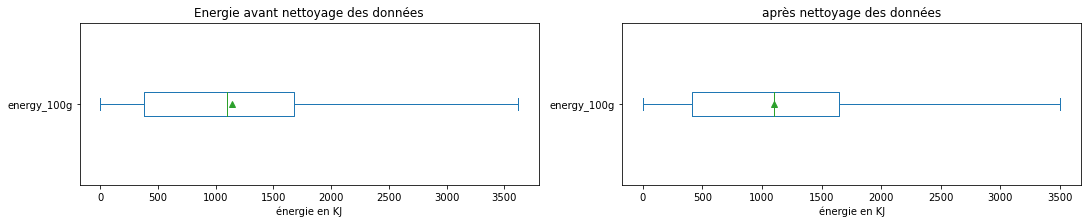

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,3))
ax3 = data['energy_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax3.set_xlabel("énergie en KJ")
ax3.set_title("Energie avant nettoyage des données")

ax4 = data_etudiee['energy_100g'].plot.box(showfliers=False, showmeans = True, vert = False,ax=axes[1])
ax4.set_xlabel("énergie en KJ")
ax4.set_title("après nettoyage des données")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

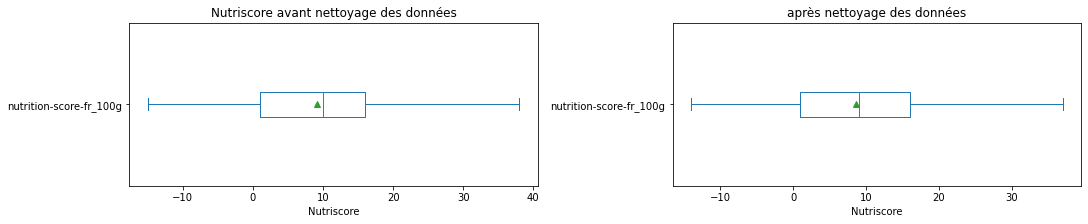

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,3))
ax5 = data['nutrition-score-fr_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax5.set_xlabel("Nutriscore")
ax5.set_title("Nutriscore avant nettoyage des données")

ax6 = data_etudiee['nutrition-score-fr_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax6.set_xlabel("Nutriscore")
ax6.set_title("après nettoyage des données")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

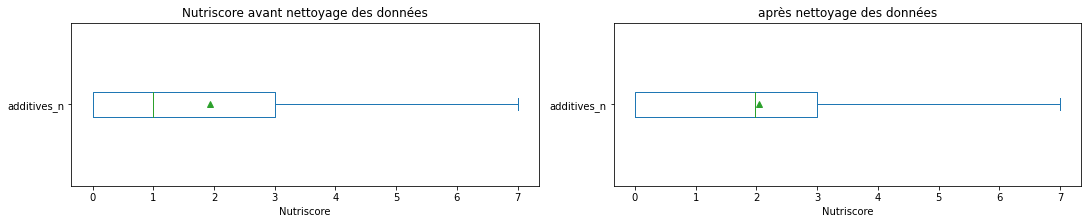

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,3))
ax5 = data[quanti_nbr].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax5.set_xlabel("Nutriscore")
ax5.set_title("Nutriscore avant nettoyage des données")

ax6 = data_etudiee[quanti_nbr].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax6.set_xlabel("Nutriscore")
ax6.set_title("après nettoyage des données")
plt.show

In [22]:
print("Calculs statistiques avant nettoyage")
data[quanti_100g + quanti_energie+ quanti_nbr].describe()

Calculs statistiques avant nettoyage


,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,fiber_100g,energy_100g,additives_n
count,259922.000000,255463.000000,243891.000000,243588.000000,200886.000000,2.611130e+05,248939.000000
mean,7.075940,0.798815,12.730379,32.073981,2.862111,1.141915e+03,1.936024
std,8.409054,50.504428,17.578747,29.731719,12.867578,6.447154e+03,2.502019
min,-800.000000,0.000000,0.000000,0.000000,-6.700000,0.000000e+00,0.000000
25%,0.700000,0.025000,0.000000,6.000000,0.000000,3.770000e+02,0.000000
50%,4.760000,0.229000,5.000000,20.600000,1.500000,1.100000e+03,1.000000
75%,10.000000,0.541000,20.000000,58.330000,3.600000,1.674000e+03,3.000000
max,430.000000,25320.000000,714.290000,2916.670000,5380.000000,3.251373e+06,31.000000


In [23]:
print("Calculs statistiques après nettoyage")
data_etudiee[quanti_100g + quanti_energie + quanti_nbr].describe()

Calculs statistiques après nettoyage


,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,fiber_100g,energy_100g,additives_n
count,117355.000000,117355.000000,117355.000000,117355.000000,117355.000000,117355.000000,117355.000000
mean,6.972944,0.531756,10.203490,31.348032,2.311098,1103.735014,2.042059
std,7.329901,1.929374,12.362667,26.902783,3.125189,731.088525,2.406605
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,0.039370,0.500000,6.900000,0.000000,410.000000,0.000000
50%,5.260000,0.248031,5.360000,24.240000,1.800000,1100.000000,1.982011
75%,9.600000,0.536000,15.000000,54.200000,2.828862,1648.000000,3.000000
max,90.000000,92.500000,97.140000,100.000000,100.000000,3761.000000,31.000000


Au niveau des quantités en grammes le nettoyage réduit la dispersion, diminue la moyenne et la médiane qui se rapprochent. On constate la même chose sur la variable énergie.
En revanche sur la variable additives_n la moyenne augmente et la médiane diminue. On a donc supprimé des lignes pour lesquelles le nombre d'additifs était faible.
le rapprochement entre médiane et moyenne s'explique par le remplacement des valeurs manquantes par la moyenne de l'échantillon.

In [24]:
print("Fréquences des modalités de la variable countries_fr")
tabcountries_fr = frequence(data_etudiee, 'countries_fr')

Fréquences des modalités de la variable countries_fr
    modalités fréquences
0  États-Unis     51.05%
1      France     33.65%
2      Suisse      5.93%
3   Allemagne      2.69%
4     Espagne      1.61%
0      Autres      5.07%


Nombres de modalités :  435




Les modalités de la variable pays sont répartis de manière très inégale se qui peut rendre la comparaison par pays délicate.

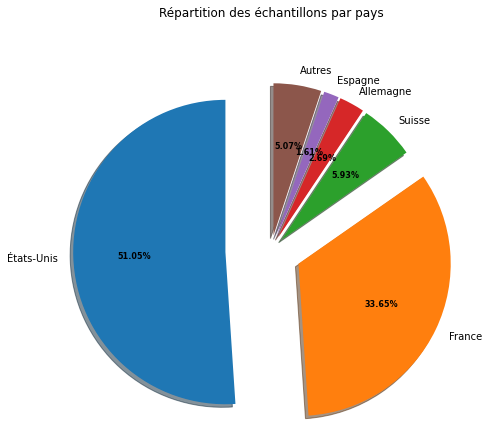

In [25]:
graph(tabcountries_fr, 'Répartition des échantillons par pays')

In [26]:
print("Fréquences des modalités de la variable brands")
tabbrands = frequence(data_etudiee,'brands')

Fréquences des modalités de la variable brands
        modalités fréquences
0  non renseignée      2.82%
1       Carrefour      1.39%
2          Auchan      1.05%
3               U      1.05%
4    Leader Price      0.84%
0          Autres     92.84%


Nombres de modalités :  26410




In [27]:
print("Fréquences des modalités de la variable main_category_fr")
tabmain_category_fr = frequence(data_etudiee,'main_category_fr')

Fréquences des modalités de la variable main_category_fr
                                 modalités fréquences
0                           non renseignée     63.58%
1                                Chocolats      1.59%
2  Aliments et boissons à base de végétaux      1.47%
3                                Conserves      1.41%
4                                 Biscuits      1.41%
0                                   Autres     30.54%


Nombres de modalités :  1560




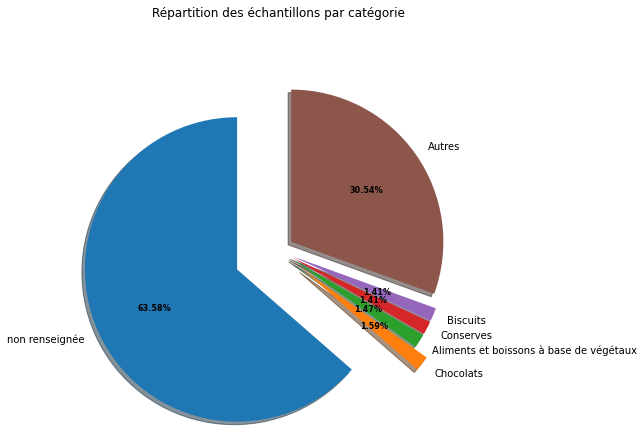

In [28]:
graph(tabmain_category_fr, 'Répartition des échantillons par catégorie')

In [29]:
print("Fréquences des modalités de la variable nutrition-letter-fr_100g")
tabnutrition_letter_fr_100g = frequence(data_etudiee,'nutrition-letter-fr_100g')

Fréquences des modalités de la variable nutrition-letter-fr_100g
  modalités fréquences
0         B     25.23%
1         E     22.55%
2         C     20.94%
3         D     18.10%
4         A     13.18%


Nombres de modalités :  5




# Focus sur les produits vendus en France

On s'adresse à des utilisateurs en France donc la suite de l'étude se limite à ces produits.
Le code permet de switcher facilement d'un pays à un autre. On peut imaginer que lorsque la base de données sera plus fournie et plus complète on pourra démultiplier sur différents pays. Actuellement ce sont les produits vendu en France pour lesquels on a un grande nombres d'échantillons et avec le meilleur taux de complétude sur la variable catégorie.

In [30]:
data_categ = data_etudiee[data_etudiee['main_category_fr'] == 'non renseignée'].copy()
test = data_categ.groupby(['countries_fr', 'main_category_fr'])['main_category_fr'].agg('count')
liste_pourc = []
liste_pays = []
for i in range(0, len(test)):
    if test.index[i][0] in tabcountries_fr['modalités'].tolist():
        data_nb_tot_pays = data_etudiee[data_etudiee['countries_fr'] == test.index[i][0]]
        nb_tot_pays=data_nb_tot_pays.shape[0]
        liste_pourc.append(round(((test[i]/nb_tot_pays)*100),2))
        liste_pays.append(test.index[i][0])
serie_pourc = pd.Series(liste_pourc, liste_pays)
print('Pourcentage de données absentes pour la variable catégorie pour les pays ayant le plus de données')
serie_pourc.sort_values(ascending=False)

Pourcentage de données absentes pour la variable catégorie pour les pays ayant le plus de données


États-Unis    99.20
Suisse        84.64
France        21.04
Allemagne      3.58
Espagne        1.01
dtype: float64

In [31]:
# Copie des données correspondants aux produits vendus en France pour la suite de l'étude
data_fr = data_etudiee[data_etudiee['countries_fr'] == 'France'].copy()

In [32]:
print('Catégorie les plus présentes :')
tabmain_category_fr_fr = frequence(data_fr, 'main_category_fr')

Catégorie les plus présentes :
        modalités fréquences
0  non renseignée     21.04%
1       Conserves      3.46%
2  Plats préparés      3.29%
3        Biscuits      3.21%
4       Chocolats      3.04%
0          Autres     65.95%


Nombres de modalités :  734




In [33]:
print('Marques les plus présentes :')
tabmain_brands_fr = frequence(data_fr, 'brands')

Marques les plus présentes :
      modalités fréquences
0     Carrefour      3.84%
1             U      3.08%
2        Auchan      3.05%
3  Leader Price      2.47%
4        Casino      2.09%
0        Autres     85.47%


Nombres de modalités :  8545




# Etude Multivariée

### Repartition des produits par nutriscore

In [34]:
# Appel de la fonction qui permet de créer la liste des couleurs
# en fonction de la lettre du nutriscore
nutri_color_dict = {}
nutri_color_dict['A'] = 'darkgreen'
nutri_color_dict['B'] = 'limegreen'
nutri_color_dict['C'] = 'yellow'
nutri_color_dict['D'] = 'orange'
nutri_color_dict['E'] = 'red'

Text(0.5, 1.0, "Répartition de l'échantillon par nutriscore")

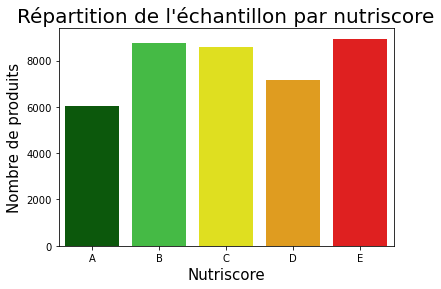

In [35]:
comptage_lettre_nutri = data_fr['nutrition-letter-fr_100g'].value_counts()
histo = sns.barplot(x=comptage_lettre_nutri.index, y=comptage_lettre_nutri.values,palette=nutri_color_dict, order=['A','B','C','D','E']);
histo.set_ylabel('Nombre de produits', fontsize = 15)
histo.set_xlabel('Nutriscore', fontsize = 15)
histo.set_title('Répartition de l\'échantillon par nutriscore', fontsize = 20)

Le nombre de produit par lettre de nutriscore n'est pas identique. On a donc potentiellement un biais.

### Répartition des produits par catégorie

In [36]:
unPas = 20
nb_deb = 0
nb_fin = unPas
plt_out = widgets.Output()

def graph_prod_cat(deb = 0, fin = 0):
    plt_out.clear_output(True)
    comptage_produit_categ = data_fr['main_category_fr'].value_counts().iloc[deb:fin]
    #f, ax = plt.subplots(figsize = (6,6))
    with plt_out :
        histo_cat = sns.barplot(x=comptage_produit_categ.values, y=comptage_produit_categ.index)
        histo_cat.set_ylabel('Catégories', fontsize = 15)
        histo_cat.set_xlabel('Nombre de produits', fontsize = 15)
        histo_cat.set_title('Répartition de l\'échantillon par catégories', fontsize = 20)
        plt.show()
    display(v1)
    
def maj_graph(bt):
    global nb_deb
    global nb_fin
    clear_output(True)  
    if bt.icon == 'forward' :
        nb_deb = min(nb_deb + unPas, len(data_fr['main_category_fr'].value_counts())-unPas)
        nb_fin = nb_deb + unPas       
    else :
        nb_deb = max(nb_deb - unPas, 0)
        nb_fin = nb_deb + unPas
    btMoins.disabled = (nb_deb == 0)
    btPlus.disabled = (nb_fin == len(data_fr['main_category_fr'].value_counts()))
    graph_prod_cat(deb = nb_deb, fin = nb_fin)
    
btPlus = widgets.Button(
    description='',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Voir les 10 catégories suivantes',
    icon= 'forward', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='50px', height='50px', order='2')
)
btMoins = widgets.Button(
    description='',
    disabled=True,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Voir les 10 catégories précédentes',
    icon= 'backward', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='50px', height='50px', order='1')
)

btPlus.on_click(maj_graph)
btMoins.on_click(maj_graph)
h1 = widgets.HBox([btMoins, btPlus])
v1 = widgets.VBox([plt_out,h1])
graph_prod_cat(deb = 0, fin = unPas)


La répartition des produits par catégorie est très inégalle donc on a également un biais.

### Répartition des notes nutriscore par catégorie

Text(0.5, 1.0, 'Répartition du nutriscore par catégories')

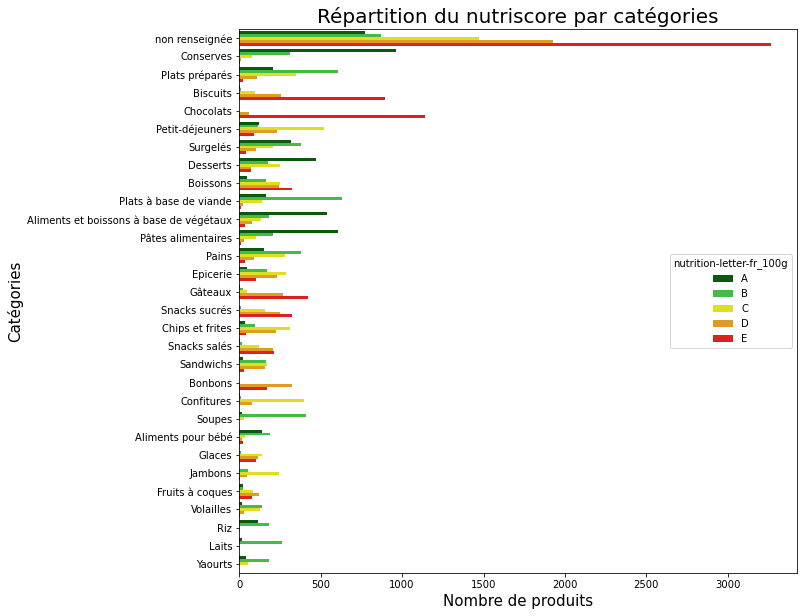

In [37]:
plt.figure(figsize=(10, 10))
ordre_categorie = data_fr['main_category_fr'].value_counts().head(30).index
histo_cat_nutri=sns.countplot(y="main_category_fr", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data_fr, order=ordre_categorie, palette=nutri_color_dict);
histo_cat_nutri.set_ylabel('Catégories', fontsize = 15)
histo_cat_nutri.set_xlabel('Nombre de produits', fontsize = 15)
histo_cat_nutri.set_title('Répartition du nutriscore par catégories', fontsize = 20)

La répartition des notes nutriscore par catégorie montre que les nutriscores D et E sont prédominants sur les catégories de produits sucrés. Les notes A et B sont majoritaires dans les catégories de produits à base de végétaux et dans celles qui regroupent des produits peu transformés.

### Répartition des notes nutriscore par marque

Text(0.5, 1.0, 'Répartition du nutriscore par marques')

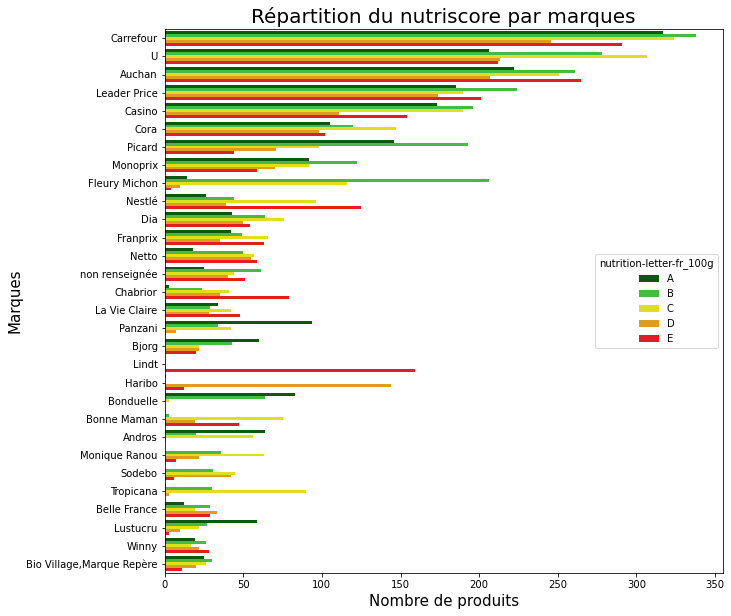

In [38]:
#cols = pltcolor(data_fr)
plt.figure(figsize=(10, 10))
ordre_categorie = data_fr['brands'].value_counts().head(30).index
histo_enseigne_nutri = sns.countplot(y="brands", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data_fr, order=ordre_categorie, palette=nutri_color_dict);
histo_enseigne_nutri.set_ylabel('Marques', fontsize = 15)
histo_enseigne_nutri.set_xlabel('Nombre de produits', fontsize = 15)
histo_enseigne_nutri.set_title('Répartition du nutriscore par marques', fontsize = 20)

On constate que les marques qui ont leur coeur de marché sur du légume ont plus de note A alors que celles qui commercialisent des bonbons ou du chocolat ont plus de D.

Le Nutriscore est-il correllé à la marque ? (ANOVA : calcul d'éta²)

In [39]:
X = "brands" # qualitative
Y = "nutrition-score-fr_100g" # quantitative    
print("Valeur d'éta² : ", eta_squared(data_fr[X],data_fr[Y]))

Valeur d'éta² :  0.5534107817450068


Le résultat indique une corrélation qu'il faut interpréter avec précaution car éta² est sensible à la quantité de variables. Nous avons vu précédement que le nombre de produits est réparti de manière très inégale tout comme le nombre de produits par nutriscore.

Le nombre d'additifs est-il correllé au nombre d'ingrédients ? (Régression linéaire)

Text(0.5, 1.0, "Corrélation nombre d'ingrédients nombre d'additifs")

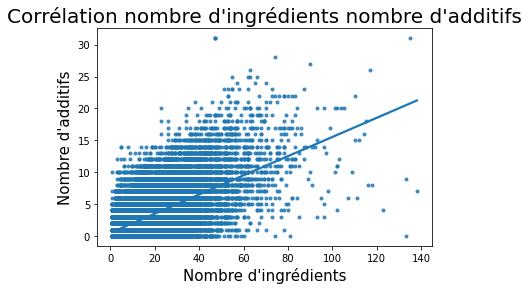

In [40]:
reg_add_ingr = sns.regplot(data = data_etudiee, x = "nb_ingredients", y = "additives_n", ci=None, marker=".")
reg_add_ingr.set_ylabel('Nombre d\'additifs', fontsize = 15)
reg_add_ingr.set_xlabel('Nombre d\'ingrédients', fontsize = 15)
reg_add_ingr.set_title('Corrélation nombre d\'ingrédients nombre d\'additifs', fontsize = 20)

Le nuage de points est assez compact mais on devine tout de même une corrélation entre le nombre d'ingrédients et le nombre d'additifs. Cette corrélation est ici représentée par le tracé de la régression linéaire.

Quelles sont les corrélations entre les différents macronutriments et l'énergie du produit ? (Tableau de contingence)

Tableau de contingence entre les variables quantitatives :


<AxesSubplot:>

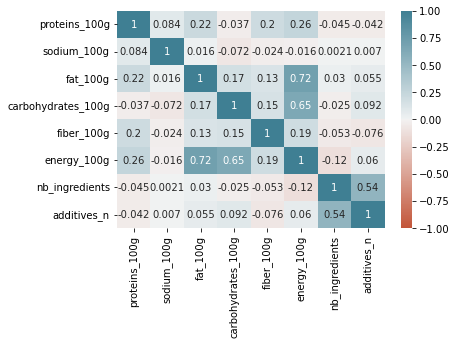

In [97]:
print('Tableau de contingence entre les variables quantitatives :')
data_fr_quanti = data_fr[quanti_100g+ quanti_energie + ['nb_ingredients'] + quanti_nbr]
sns.heatmap(data_fr_quanti.corr(),vmin=-1,vmax=1, cmap=sns.diverging_palette(20,220,as_cmap=True), annot=True)

Ce tableau met en lumière la forte corrélation entre l'énergie et la quantité de lipides et de glucides. A nouveau on voit la corrélation entre le nombre d'ingérédients et le nombre d'additifs.

Existe-il un lien entre la composition d'un produit et son nutriscore ? (utilisation de l'ACP)

In [70]:
# préparation des données pour l'ACP
#data_pca = data_etudiee[['sodium_100g','proteins_100g','fat_100g','carbohydrates_100g', 'nb_ingredients', 'additives_n']+quanti_energie]
data_pca = data_fr[["proteins_100g","sodium_100g",\
                    "fat_100g","carbohydrates_100g","fiber_100g",\
                   "additives_n","nb_ingredients"] + quanti_energie]

X = data_pca.values
names = data_pca.index
features = data_pca.columns

In [71]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [73]:
# Calcul des composantes principales
nb_var = 8
pca = decomposition.PCA(n_components=nb_var)
pca.fit(X_scaled)

PCA(n_components=8)

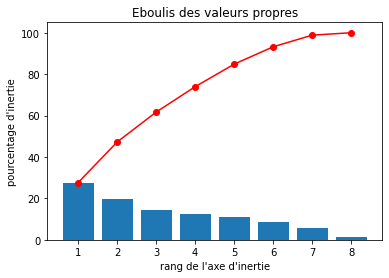

In [74]:
# eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

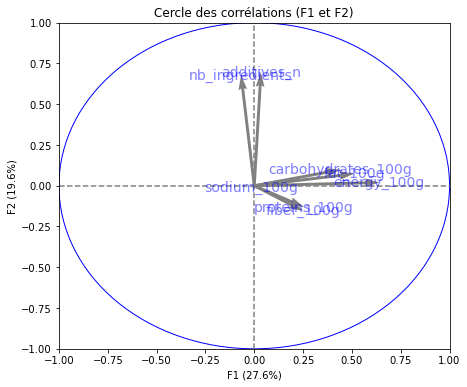

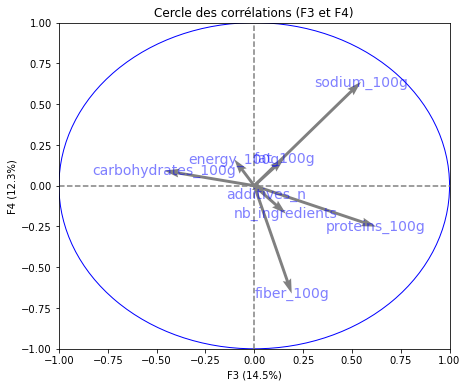

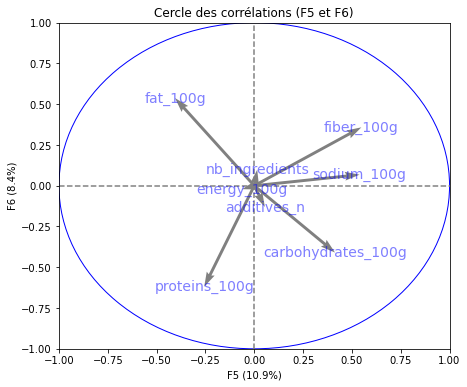

In [75]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, nb_var, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

Le premier cercle de correlation met en valeur une forte corrélation de la composition en macronutriments et de l'énergie d'un produit d'une part, d'autre part du nombre d'ingrédients et du nombre d'additifs.
L'axe F1 semble être la richesse nutritive du produit (diversité des macronutriments et quantité d'énergie apportée), l'axe F2 représente quant à lui le niveau de transformation du produits (quantité d'ingrédients et d'additifs.

In [76]:
# Appel de la fonction qui permet de créer la liste des couleurs
# en fonction de la lettre du nutriscore
cols=pltcolor(data_fr, "nutrition-score-fr_100g", nutri_color_dict)

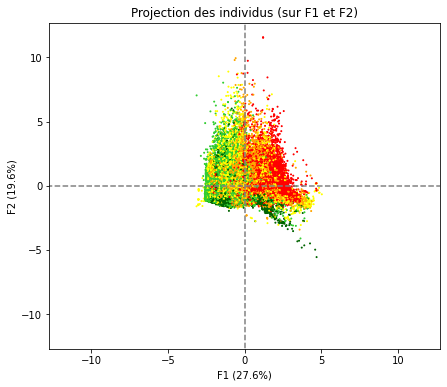

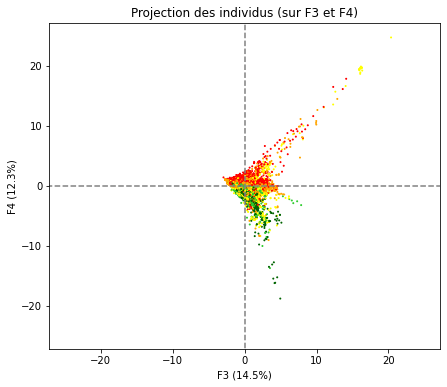

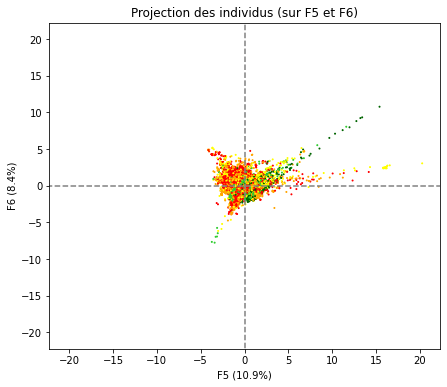

In [77]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, nb_var, pca, [(0,1), (2,3),(4,5)], labels = None, colors=list(cols))

plt.show()

La projection des individus sur les axes F1, F2 et leur coloration en fonction du nutriscore nous montre des regroupement de points de couleurs assez homogènes avec des espaces de transitions. Une tendance semble aparaitre : plus le produit est nutritif et plus la note nutriscore est mauvaise. Dans une moindre mesure le taux de transformation semble influer sur la note. En effet la pluspart des points avec le nutriscore A semblent être positionnées en dessous de l'axe des abscisses (produits peu transformés), les points avec le nutriscore B sont quant à eux regroupés essentiellement à gauche de l'axe des ordonnées (produits nutritionnellement moins riches). Enfin les produits avec un nutriscore D sont essentiellement à droite de l'axe des ordonnées (produits nutrionellement riche).
Le nutriscore est donc bien lié à la composition du produit et plus particulièrement aux quantités de chaque type de macronutriments et peu à la quantité d'ingrédients ou d'additifs. 

Existe-il un lien entre la composition d'un produit et sa catégorie ?

In [85]:
ordre_categorie = data_fr['main_category_fr'].value_counts().head(30).index
ordre_categorie

Index(['non renseignée', 'Conserves', 'Plats préparés', 'Biscuits',
       'Chocolats', 'Petit-déjeuners', 'Surgelés', 'Desserts', 'Boissons',
       'Plats à base de viande', 'Aliments et boissons à base de végétaux',
       'Pâtes alimentaires', 'Pains', 'Epicerie', 'Gâteaux', 'Snacks sucrés',
       'Chips et frites', 'Snacks salés', 'Sandwichs', 'Bonbons', 'Confitures',
       'Soupes', 'Aliments pour bébé', 'Glaces', 'Jambons', 'Fruits à coques',
       'Volailles', 'Riz', 'Laits', 'Yaourts'],
      dtype='object')

In [90]:
data_fr_filtree = data_fr.query("main_category_fr == ['Conserves','Biscuits','Fromages', 'Jambons', 'Pâtes alimentaires']")
#data_fr_filtree = data_fr.query("main_category_fr == ['Bonbons', 'Plats à base de viande', 'Soupes']")
data_pca_filtree = data_fr_filtree[["proteins_100g","sodium_100g",\
                    "fat_100g","carbohydrates_100g","fiber_100g",\
                    "additives_n","nb_ingredients"] + quanti_energie]

In [91]:
cols_categ_dict ={}
cols_categ_dict['Fromages'] = 'blue'
cols_categ_dict['Biscuits'] = 'black'
cols_categ_dict['Conserves'] = 'green'
cols_categ_dict['Jambons'] = 'red'
cols_categ_dict['Pâtes alimentaires'] = 'orange'

# Génération de la liste des couleurs
cols=pltcolor(data_fr_filtree, 'main_category_fr', cols_categ_dict)

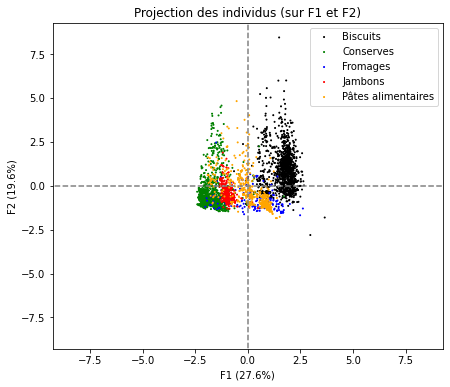

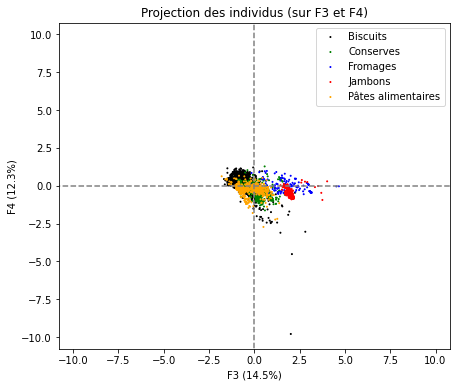

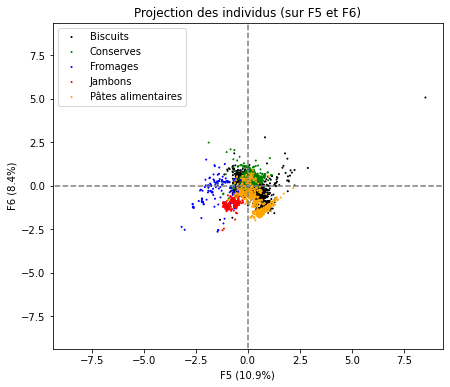

In [92]:

X_filtree = data_pca_filtree.values
names_filtree = data_pca_filtree.index
features_filtree = data_pca_filtree.columns
std_scale_filtree = preprocessing.StandardScaler().fit(X_filtree)
X_scaled_filtree = std_scale.transform(X_filtree)
X_projected_filtree = pca.transform(X_scaled_filtree)
display_factorial_planes(X_projected_filtree, nb_var, pca, [(0,1), (2,3),(4,5)], labels = None, illustrative_var = np.array(data_fr_filtree['main_category_fr'].values), colors = np.array(cols))

plt.show()


Si on prend des catégories assez éloignées dans les produits qu'elles peuvent contenir on peut mettre en valeur une homogénéité des produits qui la composent sur les axes F1, F2.
Par exemple la catégorie des biscuits est clairement positionnée à droite de l'axe des ordonnées avec une forte dispersion verticale (produits très nutritif et potentiellement très transformé) alors que le fromage est très regroupé à droite de laxe vertical et en dessous de l'axe horisontal (produit très nutritif et peu transformé)